# Marketing Text Classification with K-Train

This document is the final project for DTSA 5798: Supervised Text Classification. I build a text classification model that distinguishes articles in the "HEALTHY LIVING/WELLNESS" category from other categories.I would simplify deep learning processes with pre-trained models for training and evaluation.

## About the final project

Imagine you're working at a media buying company, Chrishare. They have a new client, Theragun. 

Theragun knows that consumers who value health and wellness are more likely to consider, and ultimately buy their product. So, they’d like to find health and wellness news around the web to advertise on. Their goal with their media campaign is to identify as many news articles that mention health and wellness as possible. 

This is called contextual advertising: finding the URLs that match the context in which you’d like your ad to be shown. If you want to learn more about contextual advertising, I humbly recommend my non-credit Digital Advertising Strategy specialization on Coursera!

Your challenge now is to build a deep learning algorithm that predicts the probability that a news story is about health and wellness. You’ll be using the k-train, which is a wrapper for Tensorflow, Keras, and Huggingface Transformers.

## Imports

We're using an API wrapper for Tensorflow called ktrain:

https://github.com/amaiya/ktrain

* python ==3.10
* ktrain ==0.41
* tensorflow ==2.18
* nltk 

In [ ]:
# ! pip uninstall ktrain -y
# ! pip install ktrain

In [ ]:
# ! pip uninstall tensorflow -y
# ! pip install tensorflow
# ! pip install Seaborn
# ! pip install nltk

In [ ]:
# ! pip install tf_keras


In [ ]:
! pip show tf_keras

Name: tf_keras
Version: 2.18.0
Summary: Deep learning for humans.
Home-page: https://keras.io/
Author: Keras team
Author-email: keras-users@googlegroups.com
License: Apache 2.0
Location: /home/zzz/miniconda3/envs/ttk/lib/python3.10/site-packages
Requires: tensorflow
Required-by: 


In [1]:
import os
os.environ['TF_USE_LEGACY_KERAS']="1"

In [2]:
import os
import ktrain
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

BATCH_SIZE = 16 
SAMPLE_COUNT = 20000

MAXLEN = 512

## Show  GPU information
Ensure GPU availability

In [8]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Feb 20 20:59:33 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.59                 Driver Version: 561.19         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3070 ...    On  |   00000000:01:00.0 Off |                  N/A |
| N/A   52C    P8             15W /  129W |      37MiB /   8192MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Load the data

The data file should be in  Google Drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
path = "drive/MyDrive/Text_CUB/P1_Final/"



#For local run
path = './'
file = "news_category_trainingdata.json"
news = pd.read_json(path + file)

## Inspect the data

The dataset contains several fields such as category, headline, authors, link, short_description, and date.

In [4]:
news.head()

,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26


Check the data for missing empty data

In [5]:
news.info()

news.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200853 entries, 0 to 200852
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   category           200853 non-null  object        
 1   headline           200853 non-null  object        
 2   authors            200853 non-null  object        
 3   link               200853 non-null  object        
 4   short_description  200853 non-null  object        
 5   date               200853 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(5)
memory usage: 10.7+ MB


category             0
headline             0
authors              0
link                 0
short_description    0
date                 0
dtype: int64

To view which categories of data are ranked

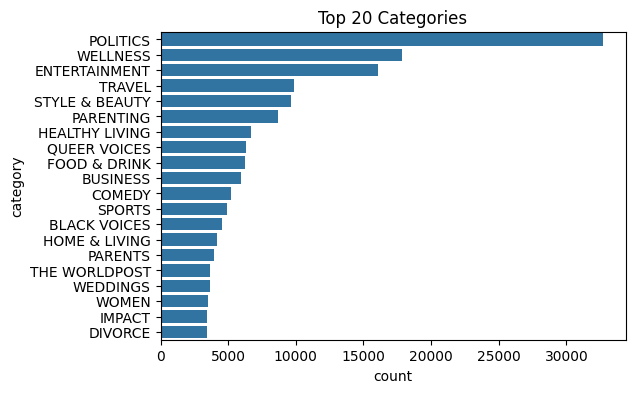

In [7]:
news_cat_count =news["category"].value_counts().head(20)

type(news_cat_count)

f = plt.figure(figsize=(6,4))
sns.barplot(x = 'count',
            y = 'category',
            data =news_cat_count.reset_index().rename(columns = {'index':'category','category':'count'})
            ).set(title='Top 20 Categories')
plt.show()

## Prepare the data

Most machine learning tools in Python accept one column. So we have to merge our two text column. Let's separate it with a space. All text data used for training will be merged into a single column.


In [8]:
news['combined_text'] = news['headline'] + ' ' + news['short_description']

 when an article belongs to the 'HEALTHY LIVING' or 'WELLNESS' categories, it should be marked with a 1; for any other category, it should be marked with a 0.

In [9]:
well_cat = ['HEALTHY LIVING', 'WELLNESS']
news['H&W'] = np.where((news['category'].isin(well_cat)), 1, 0)
news.head()


,category,headline,authors,link,short_description,date,combined_text,H&W
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26,There Were 2 Mass Shootings In Texas Last Week...,0
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26,Will Smith Joins Diplo And Nicky Jam For The 2...,0
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26,Hugh Grant Marries For The First Time At Age 5...,0
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,0
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26,Julianna Margulies Uses Donald Trump Poop Bags...,0


In [10]:
news['H&W'].describe()

count    200853.000000
mean          0.122084
std           0.327384
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: H&W, dtype: float64

The data appears to be imbalanced based on the counts provided for the H&W column. Here is a breakdown of the imbalance:

* The count for 0 (articles not about Health & Wellness) is 176,332.
* The count for 1 (articles about Health & Wellness) is 24,521.

Potential Impact:
* Model Bias: An imbalanced dataset can lead to a model that is biased towards predicting the majority class 
* Performance Metrics: Standard metrics like accuracy might not be reliable. Precision, recall, and F1-score should be considered instead
* Training Efficiency: The model might learn more from the majority class, potentially overlooking patterns in the minority class

In [11]:
news['H&W'].value_counts()

0    176332
1     24521
Name: H&W, dtype: int64

## Balance the data



In order to ensure the effectiveness of model training, it is necessary to balance the ratio of positive and negative samples in the data set. Although a full balanced data set is recommended for practical applications, a smaller subset of the data is used for experimental efficiency.

To create a balanced data set that includes all of the health living articles, set sample_amount to the total number of those articles.

In [12]:
wellness = news[news['H&W'] == 1].sample(n=SAMPLE_COUNT)
not_wellness = news[news['H&W'] == 0].sample(n=SAMPLE_COUNT)

Merge the datasets of wellness and non-wellness news articles into a single DataFrame

In [13]:
news_sample = pd.concat([wellness,not_wellness])

In [14]:
news_sample.describe()

,H&W
count,40000.000000
mean,0.500000
std,0.500006
min,0.000000
25%,0.000000
50%,0.500000
75%,1.000000
max,1.000000


Remove the specified columns from the DataFrame

In [15]:
news_sample.drop(['category', 'headline', 'authors', 'link', 'short_description', 'date'], axis=1, inplace=True)


## Clean the data

We preprocessing is done to standardize and clean the textual data by removing irrelevant information such as URLs, HTML tags, punctuation, and stop words, ensuring that the remaining content is uniform and focused on meaningful words for analysis. Additionally, it helps in reducing the complexity of the text data by converting all text to lowercase, lemmatizing words to their base forms, and eliminating short words, which improves the performance and accuracy of subsequent text analysis or machine learning models.

In [16]:
news_sample.head()

,combined_text,H&W
145744,Baby Shroomers And The Heroin Spike: 6 Surpris...,1
137836,Recessions Associated With Cognitive Decline I...,1
193541,More Surprising Advice From A Centenarian: Go ...,1
33611,Millions Of These Knives Are Being Recalled Be...,1
149920,How and Why We Age: The Power of Telomeres and...,1


In [17]:
import re
import string
import nltk
import pandas as pd
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
# retrieve english stop words
stop_words = set(stopwords.words('english'))

# Converts text to lower case
def convert_to_lowercase(text):
    if pd.isna(text):
        return text
    if isinstance(text, str):
        return text.lower()
    return text

# Remove all punctuation from the text
def remove_punctuation(text):
    if pd.isna(text):
        return text
    text = re.sub(f'[{string.punctuation}]', '', text)
    return text

# Removes all numbers from the text
def remove_numbers(text):
    if pd.isna(text):
        return text
    text = re.sub(r'\d+', '', text)
    return text

# Text segmentation, then remove the length of 2 or less and the single word and stop word
def remove_short_words_and_stop_words(text):
    if pd.isna(text):
        return text
    words = word_tokenize(text)
    words = [word for word in words if len(word) > 2 and word not in stop_words]
    cleaned_text = ' '.join(words)
    return cleaned_text

# Replace two or more consecutive Spaces with a single space
def remove_multiple_spaces(text):
    if pd.isna(text):
        return text
    cleaned_text = re.sub(r' {2,}', ' ', text)
    return cleaned_text

# Remove urls
def remove_urls(text):
    if pd.isna(text):
        return text
    url_pattern = r'(www.|http[s]?://)(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    return re.sub(url_pattern, '', text)

# Remove htmls
def remove_html(text):
    if pd.isna(text):
        return text
    html_entities = r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});'
    return re.sub(html_entities, '', text)

# Remove @ and #
def remove_tags(text):
    if pd.isna(text):
        return text
    tag_pattern = r'@([a-z0-9]+)|#'
    return re.sub(tag_pattern, '', text)


def preprocess_text(text):
    if pd.isna(text):
        return text
    cleaned_text = re.sub(r'[^a-zA-Z\d\s]+', '',text)
    word_list = []
    for each_word in cleaned_text.split(' '):
        word_list.append((each_word).lower())
    word_list = [
        WordNetLemmatizer().lemmatize(each_word.strip()) for each_word in word_list
        if each_word not in stop_words and each_word.strip() != ''
    ]
    return " ".join(word_list)



def clean_text(df, col):
    df[col] = df[col].apply(convert_to_lowercase)
    df[col] = df[col].apply(remove_urls)
    df[col] = df[col].apply(remove_html)
    df[col] = df[col].apply(remove_tags)
    df[col] = df[col].apply(remove_numbers)
    df[col] = df[col].apply(remove_short_words_and_stop_words)
    df[col] = df[col].apply(remove_multiple_spaces) 
    df[col] = df[col].apply(preprocess_text)
    return df

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\SEELE\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\SEELE\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\SEELE\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\SEELE\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [18]:
news_sample = clean_text(news_sample, 'combined_text')

View the cleaned data

In [19]:
news_sample.head()

,combined_text,H&W
145744,baby shroomers heroin spike surprising trend a...,1
137836,recession associated cognitive decline old age...,1
193541,surprising advice centenarian flow greataunt l...,1
33611,million knife recalled blade break massive rec...,1
149920,age power telomere telomerase twenty year ago ...,1


We count the number of cleaned words in order to set the appropriate MAXLEN

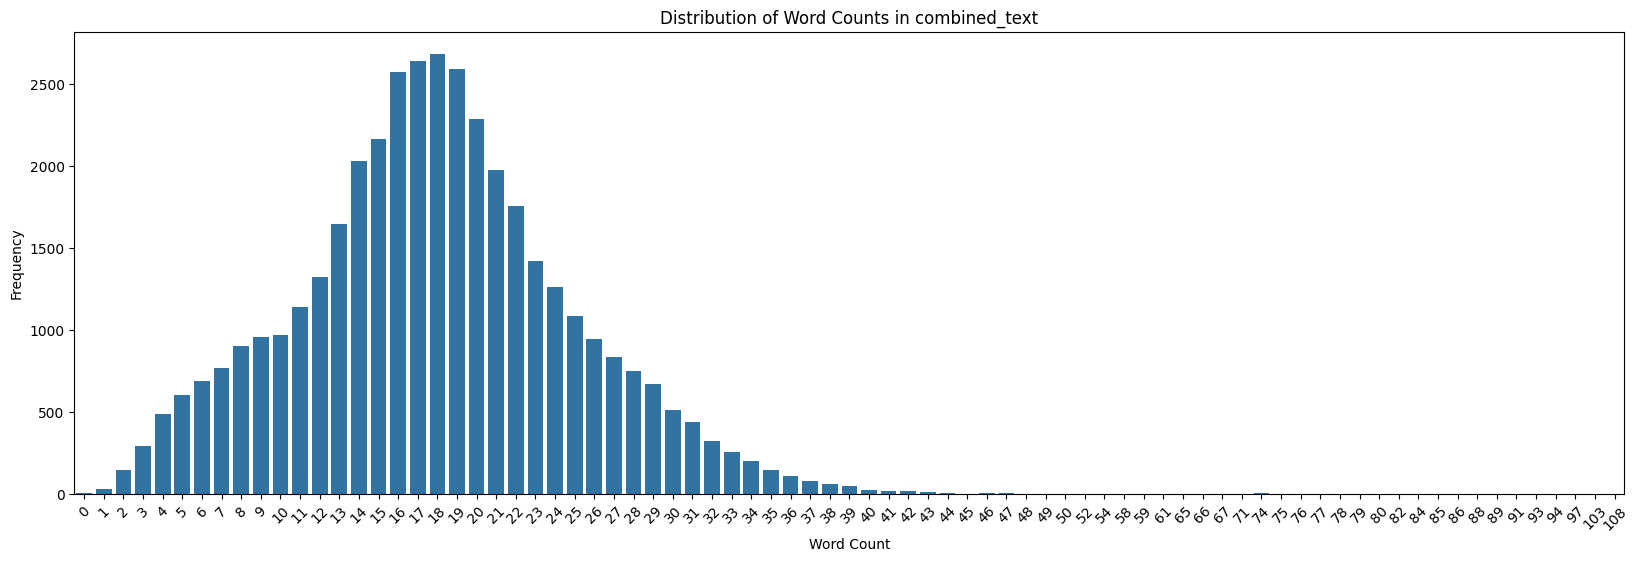

In [25]:

def count_words(text):
    return len(text.split())

news_sample['word_count'] = news_sample['combined_text'].apply(count_words)

word_count_stats = news_sample['word_count'].value_counts().reset_index()
word_count_stats.columns = ['word_count', 'frequency']

plt.figure(figsize=(20, 6))
sns.barplot(x='word_count', y='frequency', data=word_count_stats)
plt.title('Distribution of Word Counts in combined_text')
plt.xlabel('Word Count')
plt.xticks(rotation=45)
plt.ylabel('Frequency')
plt.show()

In [20]:
MAXLEN = 128

# Model Training

Different text classifier models were selected for experiments, 
including **distilbert**, **fasttext**, and **nbsvm**. 

- **DistilBERT** : Lightweight BERT variant for fast training.
- **FastText** : Fast classifier based on bag of words model.
- **NBSVM** : Traditional linear model, dependent on word frequency characteristics.

For each model, the following steps need to be performed:

- Use the 'texts_from_df' method to extract training and validation data from the DataFrame.
- Define and compile the model.
- Find the best parameters using an automatically adjusted learning rate and apply an early stop strategy to avoid overfitting.

In [29]:
# referenced document
# https://github.com/amaiya/ktrain/blob/master/tutorials/tutorial-04-text-classification.ipynb


#view all models
ktrain.text.print_text_classifiers()


fasttext: a fastText-like model [http://arxiv.org/pdf/1607.01759.pdf]
logreg: logistic regression using a trainable Embedding layer
nbsvm: NBSVM model [http://www.aclweb.org/anthology/P12-2018]
bigru: Bidirectional GRU with pretrained fasttext word vectors [https://fasttext.cc/docs/en/crawl-vectors.html]
standard_gru: simple 2-layer GRU with randomly initialized embeddings
bert: Bidirectional Encoder Representations from Transformers (BERT) from keras_bert [https://arxiv.org/abs/1810.04805]
distilbert: distilled, smaller, and faster BERT from Hugging Face transformers [https://arxiv.org/abs/1910.01108]


In [21]:
target_names = ['not wellness','wellness']

## Model A: distilbert
 [https://arxiv.org/abs/1910.01108]
 
DistilBERT is a lightweight and efficient natural language processing model that retains much of the performance of BERT while being faster and requiring less computational power. It achieves this by distilling knowledge from a larger BERT model

In [29]:
# release GPU memory for next training
# ktrain.release_gpu_memory()
train1, val1, preprocess1 = ktrain.text.texts_from_df(
    news_sample,
    "combined_text",
    label_columns=["H&W"],
    val_df=None,
    max_features=20000,
    maxlen=MAXLEN,
    val_pct=0.2,
    ngram_range=1,
    preprocess_mode= "distilbert",
    verbose=1
)

['not_H&W', 'H&W']
        not_H&W  H&W
152814      0.0  1.0
99141       0.0  1.0
114142      0.0  1.0
141547      0.0  1.0
94937       1.0  0.0
['not_H&W', 'H&W']
        not_H&W  H&W
2147        1.0  0.0
189681      0.0  1.0
18893       1.0  0.0
152600      1.0  0.0
11961       1.0  0.0


I0000 00:00:1740056390.687623    9831 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5564 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070 Ti Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


preprocessing train...
language: en
train sequence lengths:
	mean : 18
	95percentile : 30
	99percentile : 36


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 18
	95percentile : 30
	99percentile : 36


In [30]:
modelA = ktrain.text.text_classifier('distilbert', train1, preproc=preprocess1)
learnerA = ktrain.get_learner(modelA, train_data=train1, val_data=val1, batch_size=BATCH_SIZE)

Is Multi-Label? False
maxlen is 128
done.


In [31]:
learnerA.lr_find(max_epochs=6)

simulating training for different learning rates... this may take a few moments...
Epoch 1/6
2000/2000 [==============================] - 231s 108ms/step - loss: 0.5355 - accuracy: 0.7249
Epoch 2/6
2000/2000 [==============================] - 227s 111ms/step - loss: 0.2712 - accuracy: 0.8924
Epoch 3/6
2000/2000 [==============================] - 227s 110ms/step - loss: 0.3943 - accuracy: 0.7913
Epoch 4/6
2000/2000 [==============================] - 224s 109ms/step - loss: 0.7018 - accuracy: 0.5009
Epoch 5/6
2000/2000 [==============================] - 225s 109ms/step - loss: 0.7017 - accuracy: 0.4935
Epoch 6/6
2000/2000 [==============================] - 197s 95ms/step - loss: 1043.8191 - accuracy: 0.5017


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


Three possible suggestions for LR from plot:
	Longest valley (red): 3.71E-06
	Min numerical gradient (purple): 2.05E-06
	Min loss divided by 10 (omitted from plot): 6.61E-06


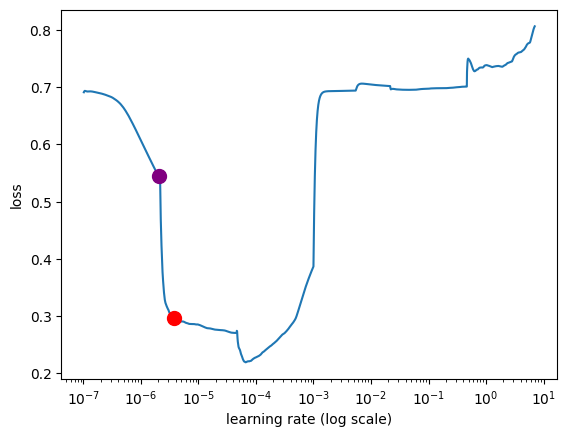

In [32]:
learnerA.lr_plot(suggest = True)

Now, use the tuned learner to train the best model.

Here, we define a limit of 10 epochs, but in reality, this should stop much sooner due to early stopping.

In [33]:
history=learnerA.autofit(
    3.71E-06,
    checkpoint_folder='checkpoint',
    epochs=10,
    early_stopping=True
)



begin training using triangular learning rate policy with max lr of 6.43e-06...
Epoch 1/10
2000/2000 [==============================] - 248s 119ms/step - loss: 0.3012 - accuracy: 0.8743 - val_loss: 0.2340 - val_accuracy: 0.9075
Epoch 2/10
2000/2000 [==============================] - 236s 118ms/step - loss: 0.2172 - accuracy: 0.9175 - val_loss: 0.2267 - val_accuracy: 0.9099
Epoch 3/10
2000/2000 [==============================] - 232s 116ms/step - loss: 0.1862 - accuracy: 0.9300 - val_loss: 0.2300 - val_accuracy: 0.9110
Epoch 3: early stopping
Restoring model weights from the end of the best epoch: 2.
Weights from best epoch have been loaded into model.


In [54]:
learnerA.model.summary()

Model: "tf_distil_bert_for_sequence_classification_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66362880  
 inLayer)                                                        
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
 dropout_59 (Dropout)        multiple                  0         
                                                                 
Total params: 66955010 (255.41 MB)
Trainable params: 66955010 (255.41 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [35]:
validation = learnerA.validate(val_data=val1, print_report=True)

250/250 [==============================] - 17s 65ms/step
              precision    recall  f1-score   support

           0       0.92      0.90      0.91      4004
           1       0.90      0.92      0.91      3996

    accuracy                           0.91      8000
   macro avg       0.91      0.91      0.91      8000
weighted avg       0.91      0.91      0.91      8000



## Model B: fasttext
[http://arxiv.org/pdf/1607.01759.pdf]

FastText is an efficient and lightweight library for text classification and representation learning that is capable of handling large-scale data efficiently. It simplifies the process of converting text into vector representations, enabling quick and effective text analysis tasks including classification and word embeddings.

In [22]:
# release GPU memory for next training



train2, val2, preprocess2 = ktrain.text.texts_from_df(
    news_sample,
    "combined_text",
    label_columns=["H&W"],
    val_df=None,
    max_features=20000,
    maxlen=MAXLEN,
    val_pct=0.2,
    ngram_range=1,
    preprocess_mode= "standard",
    verbose=1
)

['not_H&W', 'H&W']
        not_H&W  H&W
67728       1.0  0.0
79965       1.0  0.0
45395       1.0  0.0
30326       1.0  0.0
149860      0.0  1.0
['not_H&W', 'H&W']
        not_H&W  H&W
155870      0.0  1.0
68186       1.0  0.0
90899       1.0  0.0
156261      1.0  0.0
107892      0.0  1.0
language: en
Word Counts: 37235
Nrows: 32000
32000 train sequences
train sequence lengths:
	mean : 17
	95percentile : 29
	99percentile : 35
x_train shape: (32000,128)
y_train shape: (32000, 2)
Is Multi-Label? False
8000 test sequences
test sequence lengths:
	mean : 17
	95percentile : 29
	99percentile : 34
x_test shape: (8000,128)
y_test shape: (8000, 2)


In [37]:
modelB = ktrain.text.text_classifier('fasttext', train2, preproc=preprocess2)
learnerB = ktrain.get_learner(modelB, train_data=train2, val_data=val2, batch_size=BATCH_SIZE)

Is Multi-Label? False
compiling word ID features...
maxlen is 128
done.


In [38]:
learnerB.lr_find(max_epochs=6)

simulating training for different learning rates... this may take a few moments...


/home/zzz/miniconda3/envs/ttk/lib/python3.10/site-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/6
2000/2000 [==============================] - 11s 5ms/step - loss: 0.9274 - accuracy: 0.5053
Epoch 2/6
2000/2000 [==============================] - 14s 7ms/step - loss: 0.8992 - accuracy: 0.5139
Epoch 3/6
2000/2000 [==============================] - 12s 6ms/step - loss: 0.6987 - accuracy: 0.6168
Epoch 4/6
2000/2000 [==============================] - 14s 7ms/step - loss: 0.4558 - accuracy: 0.7940
Epoch 5/6
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6646 - accuracy: 0.5683
Epoch 6/6
2000/2000 [==============================] - 11s 6ms/step - loss: 0.8375 - accuracy: 0.4962


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


Three possible suggestions for LR from plot:
	Longest valley (red): 9.25E-04
	Min numerical gradient (purple): 9.55E-04
	Min loss divided by 10 (omitted from plot): 2.27E-03


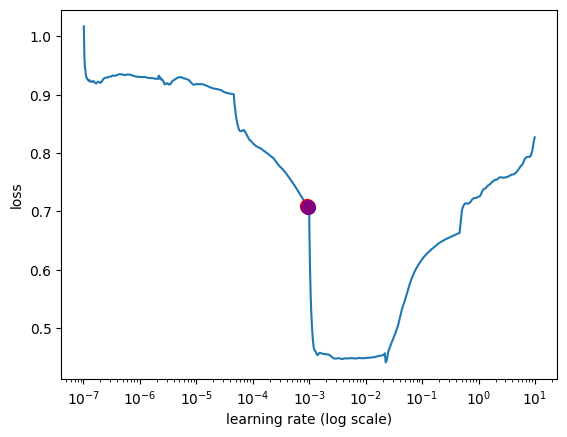

In [39]:

learnerB.lr_plot(suggest = True)

In [40]:
history=learnerB.autofit(
    4.28E-04,
    checkpoint_folder='checkpoint',
    epochs=10,
    early_stopping=True
)



begin training using triangular learning rate policy with max lr of 0.000428...
Epoch 1/10
2000/2000 [==============================] - 17s 9ms/step - loss: 0.6927 - accuracy: 0.6242 - val_loss: 0.4415 - val_accuracy: 0.8335
Epoch 2/10
2000/2000 [==============================] - 14s 7ms/step - loss: 0.4665 - accuracy: 0.7795 - val_loss: 0.3366 - val_accuracy: 0.8637
Epoch 3/10
2000/2000 [==============================] - 16s 8ms/step - loss: 0.3753 - accuracy: 0.8383 - val_loss: 0.3003 - val_accuracy: 0.8765
Epoch 4/10
2000/2000 [==============================] - 14s 7ms/step - loss: 0.3218 - accuracy: 0.8668 - val_loss: 0.2853 - val_accuracy: 0.8848
Epoch 5/10
2000/2000 [==============================] - 16s 8ms/step - loss: 0.2869 - accuracy: 0.8836 - val_loss: 0.2777 - val_accuracy: 0.8861
Epoch 6/10
2000/2000 [==============================] - 13s 7ms/step - loss: 0.2615 - accuracy: 0.8943 - val_loss: 0.2751 - val_accuracy: 0.8882
Epoch 7/10
2000/2000 [==========================

In [41]:
learnerB.model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 128, 64)           1280000   
                                                                 
 spatial_dropout1d (Spatial  (None, 128, 64)           0         
 Dropout1D)                                                      
                                                                 
 global_max_pooling1d (Glob  (None, 64)                0         
 alMaxPooling1D)                                                 
                                                                 
 batch_normalization (Batch  (None, 64)                256       
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                        

In [42]:
validation = learnerB.validate(val_data=val2, print_report=True)

250/250 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.90      0.88      0.89      3960
           1       0.88      0.90      0.89      4040

    accuracy                           0.89      8000
   macro avg       0.89      0.89      0.89      8000
weighted avg       0.89      0.89      0.89      8000



## Model C: nbsvm
[http://www.aclweb.org/anthology/P12-2018]

The NBSVM model combines the simplicity of Naive Bayes with the representational power of Support Vector Machines, making it particularly effective for text classification tasks. By leveraging the strengths of both approaches, NBSVM can achieve superior performance on datasets where feature independence assumptions are not strictly met.

In [23]:
modelC = ktrain.text.text_classifier('nbsvm', train2, preproc=preprocess2)
learnerC = ktrain.get_learner(modelC, train_data=train2, val_data=val2, batch_size=BATCH_SIZE)

Is Multi-Label? False
compiling word ID features...
maxlen is 128
building document-term matrix... this may take a few moments...
rows: 1-10000
rows: 10001-20000
rows: 20001-30000
rows: 30001-32000
computing log-count ratios...
done.


In [24]:
learnerC.lr_find(max_epochs=6)

simulating training for different learning rates... this may take a few moments...
Epoch 1/6


c:\Users\SEELE\.conda\envs\text310\lib\site-packages\tf_keras\src\engine\training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2000/2000 [==============================] - 5s 2ms/step - loss: 0.6910 - accuracy: 0.5229
Epoch 2/6
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6757 - accuracy: 0.6030
Epoch 3/6
2000/2000 [==============================] - 4s 2ms/step - loss: 0.5227 - accuracy: 0.8375
Epoch 4/6
2000/2000 [==============================] - 5s 2ms/step - loss: 0.2919 - accuracy: 0.8988
Epoch 5/6
2000/2000 [==============================] - 4s 2ms/step - loss: 0.9624 - accuracy: 0.8615


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


Three possible suggestions for LR from plot:
	Longest valley (red): 2.26E-04
	Min numerical gradient (purple): 9.52E-04
	Min loss divided by 10 (omitted from plot): 2.72E-03


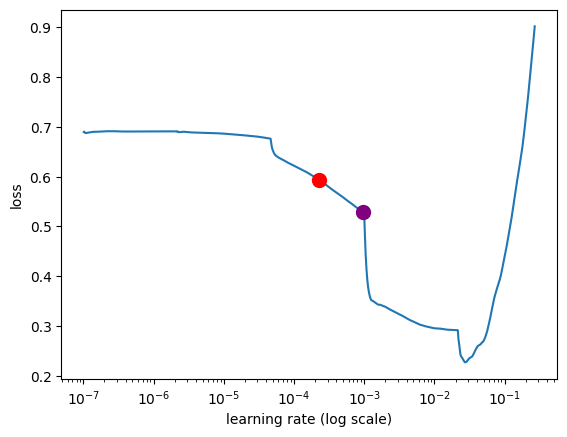

In [25]:
learnerC.lr_plot(suggest = True)

In [26]:
history=learnerC.autofit(
    2.26E-04,
    checkpoint_folder='checkpoint',
    epochs=10,
    early_stopping=True
)



begin training using triangular learning rate policy with max lr of 0.000226...
Epoch 1/10
2000/2000 [==============================] - 7s 3ms/step - loss: 0.5626 - accuracy: 0.7868 - val_loss: 0.4838 - val_accuracy: 0.8496
Epoch 2/10
2000/2000 [==============================] - 6s 3ms/step - loss: 0.4249 - accuracy: 0.8801 - val_loss: 0.4093 - val_accuracy: 0.8674
Epoch 3/10
2000/2000 [==============================] - 6s 3ms/step - loss: 0.3633 - accuracy: 0.8958 - val_loss: 0.3709 - val_accuracy: 0.8735
Epoch 4/10
2000/2000 [==============================] - 6s 3ms/step - loss: 0.3269 - accuracy: 0.9027 - val_loss: 0.3480 - val_accuracy: 0.8788
Epoch 5/10
2000/2000 [==============================] - 6s 3ms/step - loss: 0.3026 - accuracy: 0.9071 - val_loss: 0.3329 - val_accuracy: 0.8815
Epoch 6/10
2000/2000 [==============================] - 6s 3ms/step - loss: 0.2849 - accuracy: 0.9114 - val_loss: 0.3224 - val_accuracy: 0.8836
Epoch 7/10
2000/2000 [==============================] 

In [27]:
learnerC.model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128)]                0         []                            
                                                                                                  
 embedding (Embedding)       (None, 128, 2)               40000     ['input_1[0][0]']             
                                                                                                  
 embedding_1 (Embedding)     (None, 128, 1)               20000     ['input_1[0][0]']             
                                                                                                  
 dot (Dot)                   (None, 2, 1)                 0         ['embedding[0][0]',           
                                                                     'embedding_1[0][0]']     

In [28]:
validation = learnerC.validate(val_data=val2, print_report=True)

250/250 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.90      0.88      0.89      3977
           1       0.88      0.90      0.89      4023

    accuracy                           0.89      8000
   macro avg       0.89      0.89      0.89      8000
weighted avg       0.89      0.89      0.89      8000



# Model evaluation


summary  of the different models:

|   | distilbert| fasttext |  nbsvm |  Dr. Vargos' benchmark |
| ------------- | ------------- |------------- |------------- |------------- |
| trainable parameters  | 66955010 (255.41 MB)  | 1284418 (4.90 MB) | 20000 (78.12 KB) |  |
| mean f1 | 0.91 | 0.89 | 0.89 | 0.86 |


DistilBERT achieved a high F1 score mainly due to the complexity of its model architecture and the large number of parameters.Although FastText and NBSVM have far fewer parameters than DistilBERT, and they achieve slightly lower F1 scores in this case, both models may be more suitable in resource-constrained environments or applications where speed is required due to their simplicity and efficiency.

# Predictor

Get the predictor

In [ ]:
predictor = ktrain.get_predictor(learnerA.model, preproc=preprocess1)

Optionally, uncomment this code to save the predictor and reload it later. Note, the saved models can be quite large and may quickly use up space on your Google Drive.

In [50]:
predictor.save("./Model")

Let's go ahead and make a little set of test documents to check out

In [51]:
test_docs = [
'Stress May Be Your Heart’s Worst Enemy Psychological stress activates the fear center in the brain, setting into motion a cascade of reactions that can lead to heart attacks and strokes.',
'Exercising to Slim Down? Try Getting Bigger. It’s high time for women to reclaim the real strength behind exercise.',
'What Are Your Food Resolutions for the New Year? Join us for the Eat Well Challenge starting in January.',
'Why We All Need to Have More Fun. Prioritizing fun may feel impossible right now. But this four-step plan will help you rediscover how to feel more alive.',
'Cuomo Will Not Be Prosecuted in Groping Case, Albany D.A. Says. The district attorney described the woman who said former Gov. Andrew Cuomo had groped her as “credible,” but added that proving her allegation would be difficult.',
'A Film Captures Jewish Life in a Polish Town Before the Nazis Arrived. A documentary based on a home movie shot by an American in 1938 provides a look at the vibrancy of a Jewish community in Europe just before the Holocaust.'
             ]

In [52]:
for i, text in enumerate(test_docs):
  probs = predictor.predict(text, return_proba=True)
  print("---------------------------")
  print('The probability this is healthy is %s' % probs[1])
  print(text)

---------------------------
The probability this is healthy is 0.9845467
Stress May Be Your Heart’s Worst Enemy Psychological stress activates the fear center in the brain, setting into motion a cascade of reactions that can lead to heart attacks and strokes.
---------------------------
The probability this is healthy is 0.969578
Exercising to Slim Down? Try Getting Bigger. It’s high time for women to reclaim the real strength behind exercise.
---------------------------
The probability this is healthy is 0.8420893
What Are Your Food Resolutions for the New Year? Join us for the Eat Well Challenge starting in January.
---------------------------
The probability this is healthy is 0.8610504
Why We All Need to Have More Fun. Prioritizing fun may feel impossible right now. But this four-step plan will help you rediscover how to feel more alive.
---------------------------
The probability this is healthy is 0.012619637
Cuomo Will Not Be Prosecuted in Groping Case, Albany D.A. Says. The dis

*These* are pretty obvious examples, but it works exactly as expected!